In [16]:
inference_size = 1024 + 512

In [37]:
def func(a,e,alpha, max_steps = 100):
    x = a
    x_ = 2*a
    j = 0
    while abs(x_ - x) > e:
        if j > max_steps:
            break
        x = x_
        x_ = x - alpha*(x - (a/x))
        j += 1
    return x

b = func(a = 9, e = 1e-8, alpha = 0.2)
print(b)
c = func(a = 9, e = 1e-8, alpha = 1)
print(c)

3.0000000155654774
18.0


In [ ]:
d = func(a = 225, e = 1e-8, alpha = 0.1)
print(d)

15.000002057997918


In [51]:
import sys
import torch
from models import create_model
from options.test_options import TestOptions

# Path to your pre-trained weights
weights_path = "/Users/yahyarahhawi/Developer/Film/weights/New Gen/E100/180_net_G_A.pth"
# Override sys.argv to inject minimal CLI args for TestOptions
original_argv = sys.argv
sys.argv = [
    original_argv[0],
    '--dataroot', 'dummy',        # Needed to satisfy required '--dataroot' argument
    '--model', 'cycle_gan',       # Specifies the CycleGAN model
    '--dataset_mode', 'single',   # We are feeding images manually
    '--gpu_ids', '-1',
    "--netG", "resnet_9blocks" ,        # ResNet generator with 9 blocks
]

# Parse the options
opt = TestOptions().parse()

# Restore sys.argv to its original state
sys.argv = original_argv

# Set additional options manually
opt.isTrain = False  # Indicates we're running in evaluation/test mode
opt.no_dropout = True  # No dropout for inference
opt.batch_size = 1  # Inference only works with batch size = 1
opt.load_size = inference_size  # Resize to 256x256 during preprocessing (adjust as needed)
opt.crop_size = inference_size  # Crop size must match load size for this example

# Set the device to MPS if available, otherwise CPU
device = torch.device("mps")
print(f"Using device: {device}")

# Create the CycleGAN model
cycleGAN = create_model(opt)
cycleGAN.eval()  # Set the model to evaluation mode

# Manually load netG_A weights
state_dict = torch.load(weights_path, map_location=device)
cycleGAN.netG_A.load_state_dict(state_dict)

# Move the model to the device
cycleGAN.netG_A = cycleGAN.netG_A.to(device)

# Access the generator (netG_A)
model_netG_A = cycleGAN.netG_A

# Print a summary to verify everything is working
print("CycleGAN model created successfully!")
print(f"Generator loaded: {model_netG_A}")

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: dummy                         	[default: None]
             dataset_mode: single                        	[default: unaligned]
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: -1                            	[default: 0]
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_i

/var/folders/p3/zqj4hsr94qs443gkb32p5h_00000gn/T/ipykernel_79971/1096586389.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_lo

CycleGAN model created successfully!
Generator loaded: ResnetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace

In [52]:
# Create a dummy input with the same shape as your input images
dummy_input = torch.randn(1, 3, inference_size, inference_size).to(device)

# Trace the model to produce a TorchScript version
traced_model = torch.jit.trace(model_netG_A, dummy_input)

# Save the TorchScript model (optional, for debugging)
traced_model_path = "./cycleGAN_traced.pt"
traced_model.save(traced_model_path)

print(f"TorchScript model saved to {traced_model_path}")

TorchScript model saved to ./cycleGAN_traced.pt


In [53]:
import coremltools as ct
import subprocess
import os

# Convert the TorchScript model to Core ML
coreml_model = ct.convert(
    traced_model,
    inputs=[ct.ImageType(name="input", shape=(1, 3, inference_size, inference_size))],
    minimum_deployment_target=ct.target.iOS13  # Specify deployment target if needed
)

# Path for the uncompiled mlpackage
coreml_model_path = "./E100.mlpackage"

# Save the Core ML model
coreml_model.save(coreml_model_path)

print(f"Core ML model saved to {coreml_model_path}")

# Directory for compiled CoreMLC
compiled_output_dir = "./compiled_model"

# Ensure output directory exists
if not os.path.exists(compiled_output_dir):
    os.makedirs(compiled_output_dir)

# Use subprocess to call xcrun coremlc compile
compile_command = [
    "xcrun", "coremlc", "compile", coreml_model_path, compiled_output_dir
]

try:
    result = subprocess.run(compile_command, check=True, capture_output=True, text=True)
    print(f"Compiled CoreMLC model saved to {compiled_output_dir}/fuji2.mlmodelc")
except subprocess.CalledProcessError as e:
    print(f"Error during compilation: {e.stderr}")

Running MIL default pipeline:   0%|          | 0/87 [00:00<?, ? passes/s]/Users/yahyarahhawi/miniforge3/envs/pytorch/lib/python3.12/site-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:273: UserWarning: Output, '309', of the source model, has been renamed to 'var_309' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 328/328 [00:01<00:00, 241.37 ops/s]


Core ML model saved to ./E100.mlpackage
Compiled CoreMLC model saved to ./compiled_model/fuji2.mlmodelc


*Test Core ML*

In [ ]:
import coremltools as ct
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load the Core ML Model
# -------------------------------
# Path to your compiled model (mlpackage)
model_path = "/Users/yahyarahhawi/Developer/Film/pytorch-CycleGAN-and-pix2pix/p400.mlpackage"
model = ct.models.MLModel(model_path)

# Print some model spec details to verify output type
spec = model.get_spec()
if spec.description.output:
    output_feature = spec.description.output[0]
    print("Output feature name:", output_feature.name)
    # Print output type info
    print("Output type details:", output_feature.type)
else:
    print("No outputs found in the model spec.")

# -------------------------------
# 2. Prepare a Dummy Input Image
# -------------------------------
# Define the inference size (must match your model's expected input dimensions)
inference_size = 256

# Create a dummy 256x256 RGB image (here, a mid-gray image)
dummy_input_image = Image.open("/Users/yahyarahhawi/Developer/Film/pytorch-CycleGAN-and-pix2pix/datasets/Cinestill800t/train_A/whats-the-best-iphone-photo-you-have-taken-v0-cn8xdwun53wb1.webp").resize((256, 256))

# The key must match the model's input name. In our conversion, we used "input".
input_name = "input"
input_data = {input_name: dummy_input_image}

# -------------------------------
# 3. Run Prediction with the Model
# -------------------------------
result = model.predict(input_data)

# List keys of the prediction output (typically should include your output image name)
print("Prediction result keys:", list(result.keys()))

# -------------------------------
# 4. Check and Display the Output
# -------------------------------
# We assume the output is named "output". Adjust if necessary.
output = result["output"]

# In Python, image outputs from Core ML models are usually returned as NumPy arrays.
if isinstance(output, np.ndarray):
    print("Output is a NumPy array with shape:", output.shape, "and dtype:", output.dtype)
    # Clip and convert to uint8 if necessary. The model is expected to produce values in 0–255.
    output_uint8 = np.clip(output, 0, 255).astype(np.uint8)
    
    # Convert the NumPy array to a PIL Image for visualization.
    # If the array is in CHW (channels-first) format, transpose it to HWC.
    if output_uint8.shape[0] == 3:  # assume shape is (3, H, W)
        output_uint8 = np.transpose(output_uint8, (1, 2, 0))
    
    output_image = Image.fromarray(output_uint8)
    
    # Display using PIL's built-in viewer
    output_image.show()
    
    # Or display using matplotlib
    plt.imshow(output_image)
    plt.title("Model Output")
    plt.axis("off")
    plt.show()
else:
    print("Output type is:", type(output))

Output feature name: output
Output type details: imageType {
  width: 256
  height: 256
  colorSpace: RGB
}

Prediction result keys: ['output']
Output type is: <class 'PIL.Image.Image'>


In [67]:
output = np.array(output)

In [72]:
np.unique(output)

array([  0,   1, 255], dtype=uint8)

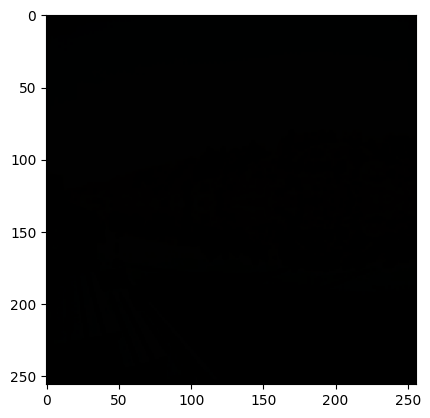

In [69]:
plt.imshow(output)